In [1]:
import gc
import glob
import os
import urllib.request
import warnings
from pathlib import Path
from typing import Dict, List, Union
from numpy.typing import NDArray
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import echopype as ep
import echopype.visualize as epviz
import fsspec
import geopandas as gpd
import hvplot.xarray
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
from echopype import open_raw
from numpy.typing import NDArray
from tqdm import tqdm

# 1. Load 38 + 120 kHz data

In [4]:
# Suppress warnings
warnings.filterwarnings("ignore")

# load 38 + 120 kHz data
folder_path = r"C:\Projects\TPOSUSV\TPOSUSV"

# Use glob to find all .raw files in the directory
raw_files = glob.glob(os.path.join(folder_path, "*.raw"))

# Sort the file paths if necessary
raw_files.sort()
raw_files = raw_files[:98] + raw_files[167:]

# Lists to hold EchoData objects
ed_lists_G2 = [[] for _ in range((len(raw_files) - 1) // 40 + 1)]

# Open each raw file and append to appropriate list
for i, raw_file in enumerate(raw_files):
    try:
        # Open the raw file with the specified sonar model (e.g., 'EK80')
        ed = ep.open_raw(raw_file, sonar_model="EK80")

        if ed["Platform"].channel.shape[0] == 2:
            list_index = i // 40
            ed_lists_G2[list_index].append(ed)

    except Exception:
        # Skip the file if there's an error, without printing the error message
        continue

# Print the number of files in each list
for i, ed_list_G2 in enumerate(ed_lists_G2):
    print(f"Files in ed_list_G2[{i+1}]: {len(ed_list_G2)}")

Files in ed_list_G2[1]: 40
Files in ed_list_G2[2]: 40
Files in ed_list_G2[3]: 12
Files in ed_list_G2[4]: 21
Files in ed_list_G2[5]: 0


In [17]:
# Combine all non-empty EchoData objects into one
combined_ed_G2 = ep.combine_echodata(
    [item for sublist in ed_lists_G2 if sublist for item in sublist]
)

# 2. Load 38 kHz data only, needs modify the open_raw function to accommendate saildrone data

In [7]:
# patch the set_vendor_specific 
@staticmethod
def _add_filter_params(
    dataset: xr.Dataset,
    coeffs_and_decimation: Dict[str, Dict[str, List[Union[int, NDArray]]]],
) -> xr.Dataset:
    # Define constants
    FILTER_IMAG = "filter_i"
    FILTER_REAL = "filter_r"
    DECIMATION = "decimation"
    WIDE_BAND_TRANS = "WBT"
    PULSE_COMPRESS = "PC"

    attribute_values = {
        FILTER_IMAG: "filter coefficients (imaginary part)",
        FILTER_REAL: "filter coefficients (real part)",
        DECIMATION: "decimation factor",
        WIDE_BAND_TRANS: "Wideband transceiver",
        PULSE_COMPRESS: "Pulse compression",
    }

    coeffs_xr_data = {}
    for cd_type, values in coeffs_and_decimation.items():
        for key, data in values.items():
            if data:
                if "filter" in key:
                    attrs = {
                        "long_name": f"{attribute_values[cd_type]} {attribute_values[key]}"
                    }
                    # filter_i and filter_r
                    max_len = np.max([len(a) for a in data])
                    # Pad arrays
                    data = np.asarray(
                        [
                            np.pad(
                                a,
                                (0, max_len - len(a)),
                                "constant",
                                constant_values=np.nan,
                            )
                            for a in data
                        ]
                    )
                    dims = ["filter_channel", f"{cd_type}_filter_n"]
                else:
                    attrs = {
                        "long_name": f"{attribute_values[cd_type]} {attribute_values[DECIMATION]}"
                    }
                    dims = ["filter_channel"]
                # Set the xarray data dictionary
                coeffs_xr_data[f"{cd_type}_{key}"] = (dims, data, attrs)

    # Create a new dataset with the filter data
    filter_ds = xr.Dataset(coeffs_xr_data)

    # Merge the original dataset with the filter dataset
    return xr.merge([dataset, filter_ds], combine_attrs="override")


# Patch the SetGroupsEK80 class method
from echopype.convert.set_groups_ek80 import SetGroupsEK80

SetGroupsEK80._add_filter_params = _add_filter_params

In [3]:
# Suppress warnings
warnings.filterwarnings("ignore")

# Load 38 kHz data
# Lists to hold EchoData objects
ed_lists_G1 = [[] for _ in range((len(raw_files) - 1) // 40 + 1)]

# Open each raw file and append to appropriate list
for i, raw_file in enumerate(raw_files):
    try:
        # Open the raw file with the specified sonar model (e.g., 'EK80')
        ed = ep.open_raw(raw_file, sonar_model="EK80")

        if ed["Platform"].channel.shape[0] == 1:
            list_index = i // 40
            ed_lists_G1[list_index].append(ed)

    except Exception:
        # Skip the file if there's an error, without printing the error message
        continue

# Print the number of files in each list
for i, ed_list_G1 in enumerate(ed_lists_G1):
    print(f"Files in ed_list_G1[{i+1}]: {len(ed_list_G1)}")

Files in ed_list_G1[1]: 0


In [10]:
# Combine all non-empty EchoData objects into one
combined_ed_G1 = ep.combine_echodata(
    [item for sublist in ed_lists_G1 if sublist for item in sublist]
)

# 3. Load GPS data 

In [15]:
# load GPS, and combine them into one file
def file_finder(folder_path, file_type):
    # Returns a list of file paths in the given folder with the specified file type
    return [
        os.path.join(folder_path, file)
        for file in os.listdir(folder_path)
        if file.endswith(file_type)
    ]


# Path to the folder containing CSV files
folder_path = r"C:\Projects\TPOSUSV\GPS"

# Get all CSV file paths in the folder
GPS_files_path = file_finder(folder_path, ".csv")

# Initialize an empty list to store DataFrames
df_list = []

# Loop through the list of file paths and read each CSV file into a DataFrame
for file_path in GPS_files_path:
    df = pd.read_csv(file_path)
    df_list.append(df)

# Concatenate all DataFrames in the list into a single DataFrame
GPS = pd.concat(df_list, ignore_index=True)

GPS.columns = ["time", "lat", "lon"]

# Check the first few rows of the combined DataFrame
print(GPS.head())

# Optionally, save the combined DataFrame to a new CSV file
# combined_GPS.to_csv(r'C:\Projects\TPOSUSV\GPS\combined_GPS_data.csv', index=False)

# # covert time format same to echosounder format
GPS["time"] = pd.to_datetime(GPS["time"])

                  time        lat         lon
0  2023-05-30 00:00:00  21.952491 -157.734874
1  2023-05-30 00:00:01  21.952506 -157.734880
2  2023-05-30 00:00:02  21.952517 -157.734887
3  2023-05-30 00:00:03  21.952529 -157.734893
4  2023-05-30 00:00:04  21.952544 -157.734895


# 4. Load calibration data

In [12]:
# Path to the Excel file
file_path = r"C:/Projects/TPOSUSV/CalibrationValues.xlsx"

# Read the Excel file into a DataFrame
cal = pd.read_excel(file_path, sheet_name="Sheet1", header=1, usecols="A:D")

# Correct the spelling and set column names
cal.columns = ["Variable", "38k short pulse", "38k long pulse", "120k short pulse"]

# Check the first few rows of the DataFramedisplay()
display(cal)

,Variable,38k short pulse,38k long pulse,120k short pulse
0,NaN,1.024 ms,2.048 ms,1.024 ms
1,Gain,19.24,18.5,18.5015
2,Alongship (minor axis) Beamwidth,17.36,16.49,16.4942
3,Athwartship (major axis) Beamwidth,16.91,16.05,16.0478
4,Alongship Offset (minor axis),0.32,0.32,0.3196
5,Athwartship Offset (major axis),-0.27,-0.43,-0.4255
6,Sa_corr,-0.07,-0.26,-0.2592


# 5. Apply GPS data to Echodata

In [13]:
def update_platform_coordinates(combined_ed, GPS):
    """
    Update the latitude and longitude in the combined_ed 'Platform' group based on GPS data.

    Parameters:
    combined_ed (EchoData): The EchoData object containing 'Platform' data.
    GPS (pd.DataFrame): The GPS data as a pandas DataFrame with 'time', 'lat', and 'lon' columns.

    Returns:
    EchoData: The updated EchoData object with latitude and longitude values updated.
    """

    # Convert GPS['time'] and combined_ed['Platform'].time1.values to numpy arrays
    gps_times = np.array(GPS["time"].values, dtype="datetime64[ns]")
    combined_times = np.array(
        combined_ed["Platform"].time1.values, dtype="datetime64[ns]"
    )

    # Create dictionaries for lat and lon with default values
    lat_dict = {}
    lon_dict = {}

    # Fill dictionaries with latitude and longitude based on time
    for t in combined_times:
        # Find the index of the closest time in GPS DataFrame
        idx = np.argmin(np.abs(gps_times - t))
        closest_time = gps_times[idx]

        # Retrieve the closest lat and lon
        lat_dict[t] = GPS.loc[GPS["time"] == closest_time, "lat"].values[0]
        lon_dict[t] = GPS.loc[GPS["time"] == closest_time, "lon"].values[0]

    # Convert dictionaries to numpy arrays
    lat_values = np.array([lat_dict[t] for t in combined_times])
    lon_values = np.array([lon_dict[t] for t in combined_times])

    # Update the latitude and longitude in the combined_ed 'Platform' group
    combined_ed["Platform"].latitude.values = lat_values
    combined_ed["Platform"].longitude.values = lon_values

    return combined_ed

In [14]:
combined_ed_G1 = update_platform_coordinates(combined_ed_G1, GPS)
combined_ed_G2 = update_platform_coordinates(combined_ed_G2, GPS)

# 6. Extract GPS from Echodata, and generate map

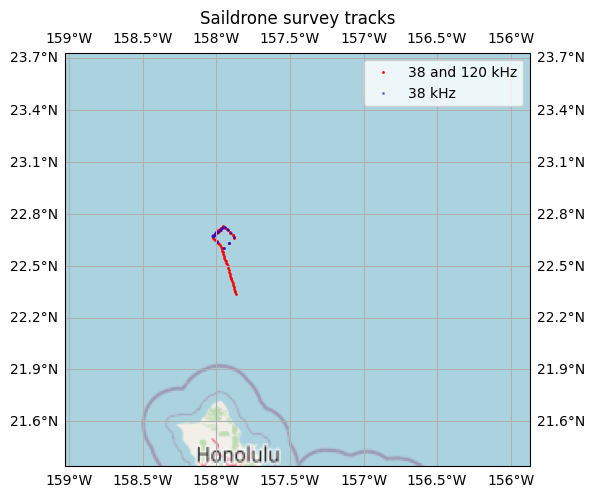

In [24]:
def extract_gps_gdf(combined_ed_list):
    """
    Extract the GPS coordinates from multiple combined_ed 'Platform' groups and return a combined GeoDataFrame.

    Parameters:
    combined_ed_list (list of EchoData): List of EchoData objects containing 'Platform' data.

    Returns:
    combined_gdf (GeoDataFrame): A combined GeoDataFrame containing the latitude and longitude points from all datasets.
    """
    # Initialize an empty list to store individual GeoDataFrames
    gdf_list = []

    for combined_ed in combined_ed_list:
        # Convert the latitude and longitude data to a DataFrame
        gps_df = (
            combined_ed["Platform"]
            .latitude.to_dataframe()
            .join(combined_ed["Platform"].longitude.to_dataframe())
        )

        # Create a GeoDataFrame with geometry points based on latitude and longitude
        gps_gdf = gpd.GeoDataFrame(
            gps_df,
            geometry=gpd.points_from_xy(gps_df["longitude"], gps_df["latitude"]),
            crs="epsg:4326",
        )

        # Append to the list
        gdf_list.append(gps_gdf)

    # Concatenate all GeoDataFrames into a single GeoDataFrame
    combined_gdf = pd.concat(gdf_list, ignore_index=True)

    # Ensure combined_gdf is a GeoDataFrame
    combined_gdf = gpd.GeoDataFrame(combined_gdf, geometry="geometry", crs="epsg:4326")

    return combined_gdf

    # List of EchoData objects


combined_ed_list = [combined_ed_G1, combined_ed_G2]

# Extract combined GeoDataFrame
combined_gdf = extract_gps_gdf(combined_ed_list)

# Create a basemap using OpenStreetMap
basemap = cimgt.OSM()
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={"projection": basemap.crs})

# Set the extent of the plot based on the bounds of the geometry points
bnd = combined_gdf.geometry.bounds
ax.set_extent(
    [bnd.minx.min() - 1, bnd.maxx.max() + 2, bnd.miny.min() - 1, bnd.maxy.max() + 1]
)

# Add the basemap and gridlines
ax.add_image(basemap, 7)
ax.gridlines(
    draw_labels=True, xformatter=LONGITUDE_FORMATTER, yformatter=LATITUDE_FORMATTER
)

# Plot the GPS points on the map with different colors
gdf_G1 = extract_gps_gdf([combined_ed_G1])
gdf_G2 = extract_gps_gdf([combined_ed_G2])

gdf_G2.plot(
    ax=ax,
    markersize=1,
    color="red",
    transform=ccrs.PlateCarree(),
    label="38 and 120 kHz",
)
gdf_G1.plot(
    ax=ax,
    markersize=1,
    color="blue",
    alpha=0.5,
    transform=ccrs.PlateCarree(),
    label="38 kHz",
)

# Add legend
ax.legend(loc="upper right")

# Add title
plt.title("Saildrone survey tracks")

plt.show()

# 7. Apply Calibration to Echodata

In [25]:
display(cal)

,Variable,38k short pulse,38k long pulse,120k short pulse
0,NaN,1.024 ms,2.048 ms,1.024 ms
1,Gain,19.24,18.5,18.5015
2,Alongship (minor axis) Beamwidth,17.36,16.49,16.4942
3,Athwartship (major axis) Beamwidth,16.91,16.05,16.0478
4,Alongship Offset (minor axis),0.32,0.32,0.3196
5,Athwartship Offset (major axis),-0.27,-0.43,-0.4255
6,Sa_corr,-0.07,-0.26,-0.2592


In [26]:
# calibrate 38 kHz only, i.e. combined_ed_G1
repeat_times = combined_ed_G1["Vendor_specific"].pulse_length_bin.shape[0]
# gain
value1_array = np.tile(cal.iloc[1, 2], repeat_times)
value2_array = np.tile(cal.iloc[1, 3], repeat_times)
gain_correction = np.vstack([value1_array, value2_array])

# along beamwidth
alongship_beamwidth = np.array([cal.iloc[2, 2]])

# athwarth beam width
athwarth_beamwidth = np.array([cal.iloc[3, 2]])

# Alongship offset
alongship_offset = np.array([cal.iloc[4, 2]])

# Athwartship offset
athwarth_offset = np.array([cal.iloc[5, 2]])

# Sa_corr
value1_array = np.tile(cal.iloc[6, 2], 5)
value2_array = np.tile(cal.iloc[6, 3], 5)
sa_correction = np.vstack([value1_array, value2_array])

# apply calibration values
combined_ed_G1["Vendor_specific"].gain_correction.values = gain_correction
combined_ed_G1.beam.beamwidth_twoway_alongship.values = alongship_beamwidth
combined_ed_G1.beam.beamwidth_twoway_athwartship.values = athwarth_beamwidth
combined_ed_G1.beam.angle_offset_alongship.values = alongship_offset
combined_ed_G1.beam.angle_offset_athwartship.values = athwarth_offset
combined_ed_G1["Vendor_specific"].sa_correction.values = sa_correction

In [27]:
# calibrate 38 +120 kHz, i.e. combined_ed_G2
repeat_times = combined_ed_G2["Vendor_specific"].pulse_length_bin.shape[0]
# gain
value1_array = np.tile(cal.iloc[1, 1], repeat_times)
value2_array = np.tile(cal.iloc[1, 3], repeat_times)
gain_correction = np.vstack([value1_array, value2_array])

# along beamwidth
alongship_beamwidth = np.array([cal.iloc[2, 1], cal.iloc[2, 3]])

# athwarth beam width
athwarth_beamwidth = np.array([cal.iloc[3, 1], cal.iloc[3, 3]])

# Alongship offset
alongship_offset = np.array([cal.iloc[4, 1], cal.iloc[4, 3]])

# Athwartship offset
athwarth_offset = np.array([cal.iloc[5, 1], cal.iloc[5, 3]])

# Sa_corr
value1_array = np.tile(cal.iloc[6, 1], 5)
value2_array = np.tile(cal.iloc[6, 3], 5)
sa_correction = np.vstack([value1_array, value2_array])

# apply calibration values
combined_ed_G2["Vendor_specific"].gain_correction.values = gain_correction
combined_ed_G2.beam.beamwidth_twoway_alongship.values = alongship_beamwidth
combined_ed_G2.beam.beamwidth_twoway_athwartship.values = athwarth_beamwidth
combined_ed_G2.beam.angle_offset_alongship.values = alongship_offset
combined_ed_G2.beam.angle_offset_athwartship.values = athwarth_offset
combined_ed_G2["Vendor_specific"].sa_correction.values = sa_correction

# 8. Convert to Zarr and save to new files 

In [28]:
# correct sound_velocity_profile_depth for saving to Zarr (Division by zero)

# Access the DataArray and use `assign_coords` to update the coordinate values
combined_ed_G2["Environment"] = combined_ed_G2["Environment"].assign_coords(
    sound_velocity_profile_depth=[0]
)
combined_ed_G1["Environment"] = combined_ed_G1["Environment"].assign_coords(
    sound_velocity_profile_depth=[0]
)

In [29]:
# save to Zarr
combined_ed_G2.to_zarr(save_path=r"C:\Projects\TPOSUSV\converted_file_38_120.zarr")
combined_ed_G1.to_zarr(save_path=r"C:\Projects\TPOSUSV\converted_file_38.zarr")

# 9. Reload Zarr files and check metadata

In [63]:
zarr_G2 = ep.open_converted(r"C:\Projects\TPOSUSV\converted_file_38_120.zarr")
zarr_G1 = ep.open_converted(r"C:\Projects\TPOSUSV\converted_file_38.zarr")

In [12]:
display(zarr_G1)
display(zarr_G2)

<EchoData: standardized raw data from C:\Projects\TPOSUSV\converted_file_38.zarr>
Top-level: contains metadata about the SONAR-netCDF4 file format.
├── Environment: contains information relevant to acoustic propagation through water.
├── Platform: contains information about the platform on which the sonar is installed.
│   └── NMEA: contains information specific to the NMEA protocol.
├── Provenance: contains metadata about how the SONAR-netCDF4 version of the data were obtained.
├── Sonar: contains sonar system metadata and sonar beam groups.
│   └── Beam_group1: contains complex backscatter data and other beam or channel-specific data.
└── Vendor_specific: contains vendor-specific information about the sonar and the data.

<EchoData: standardized raw data from C:\Projects\TPOSUSV\converted_file_38_120.zarr>
Top-level: contains metadata about the SONAR-netCDF4 file format.
├── Environment: contains information relevant to acoustic propagation through water.
├── Platform: contains information about the platform on which the sonar is installed.
│   └── NMEA: contains information specific to the NMEA protocol.
├── Provenance: contains metadata about how the SONAR-netCDF4 version of the data were obtained.
├── Sonar: contains sonar system metadata and sonar beam groups.
│   └── Beam_group1: contains complex backscatter data and other beam or channel-specific data.
└── Vendor_specific: contains vendor-specific information about the sonar and the data.

# 10. Visualise echograms

In [54]:
import matplotlib.pyplot as plt
import numpy as np

def plot_echogram(data, frequency, title, y_limit=(1300, 0), figsize=(12, 6), scale_factor=2):
    """
    Plot an echogram with specified settings and adjust the y-axis scale for display.
    
    Parameters:
    - data: The dataset to plot
    - frequency: Frequency to select from the dataset
    - title: Title of the plot
    - y_limit: Tuple specifying the y-axis limits (default is (1300, 0))
    - figsize: Size of the figure (default is (12, 6))
    - scale_factor: Factor to scale y-axis data for display (default is 2)
    """
    # Create a figure and axis with the desired figure size
    fig, ax = plt.subplots(figsize=figsize)

    # Plot the data with the desired settings
    data.Sv.sel(frequency_nominal=frequency).plot.pcolormesh(
        x='ping_time', cmap='jet', vmin=-90, vmax=-50, ax=ax
    )

    # Reverse the y-axis
    ax.invert_yaxis()

    # Set the y-axis limits normally
    ax.set_ylim(y_limit)

    # Set the y-axis title
    ax.set_ylabel("Depth (m)")

    # Set the plot title
    ax.set_title(title)

    # Adjust the aspect ratio to 'auto'
    ax.set_aspect('auto')

    # Define a custom formatter for the y-axis
    def y_formatter(value, tick_number):
        # Convert the tick value to a scaled value
        return f"{int(value / scale_factor)}"

    # Apply the custom formatter to the y-axis
    ax.yaxis.set_major_formatter(plt.FuncFormatter(y_formatter))

    # Set the y-axis ticks and labels for better visualization
    yticks = np.arange(y_limit[0], y_limit[1] - 1, -200)  # Adjust this range as needed
    ax.set_yticks(yticks)

    # Show the plot
    plt.show()

## 38 kHz long pulse full dataset

The time arrays are not equal and cannot be harmonized directly.
An error occurred: Dimension 'time1' not found in data dimensions ('ping_time',)


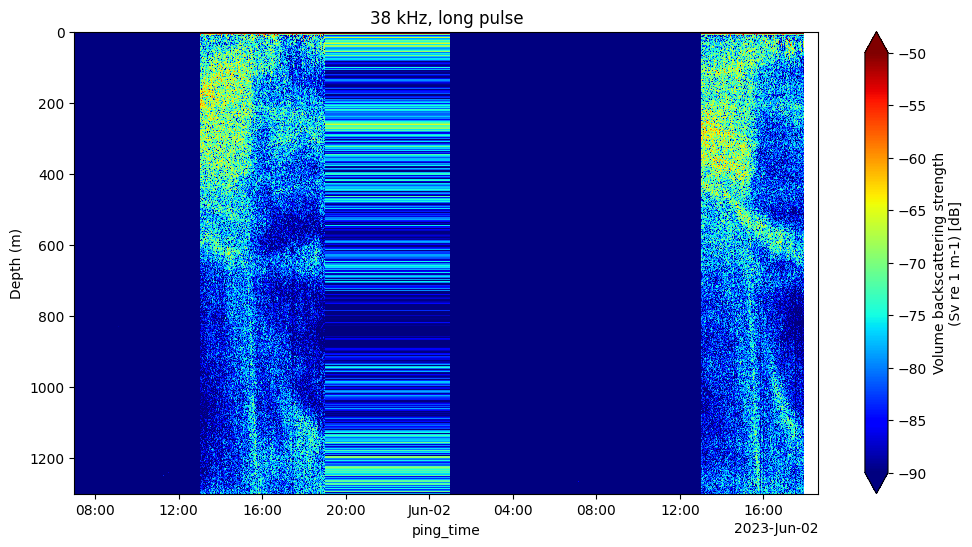

In [12]:
# see full echogram
zarr_G1["Vendor_specific"] = zarr_G2["Vendor_specific"].isel(channel=slice(1))
# For zarr_G1
Sv_G1 = ep.calibrate.compute_Sv(
    zarr_G1, waveform_mode="CW", encode_mode="complex"
).compute()
ds_Sv = ep.consolidate.swap_dims_channel_frequency(Sv_G1)
plot_echogram(ds_Sv, frequency=38000, title='38 kHz, long pulse')

## 38 kHz short pulse full dataset

The time arrays are not equal and cannot be harmonized directly.
An error occurred: Dimension 'time1' not found in data dimensions ('ping_time',)


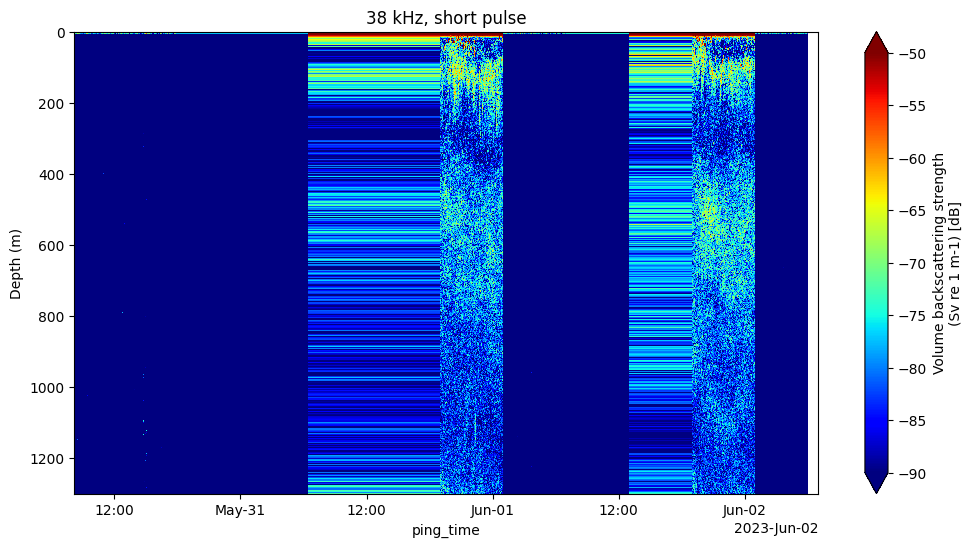

In [8]:
del Sv_G1, ds_Sv
gc.collect()

# For zarr_G2
Sv_G2 = ep.calibrate.compute_Sv(
    zarr_G2, waveform_mode="CW", encode_mode="complex"
).compute()
ds_Sv = ep.consolidate.swap_dims_channel_frequency(Sv_G2)
plot_echogram(ds_Sv, frequency=38000, title='38 kHz, short pulse')

## 200 kHz short pulse full dataset

The time arrays are not equal and cannot be harmonized directly.
An error occurred: Dimension 'time1' not found in data dimensions ('ping_time',)


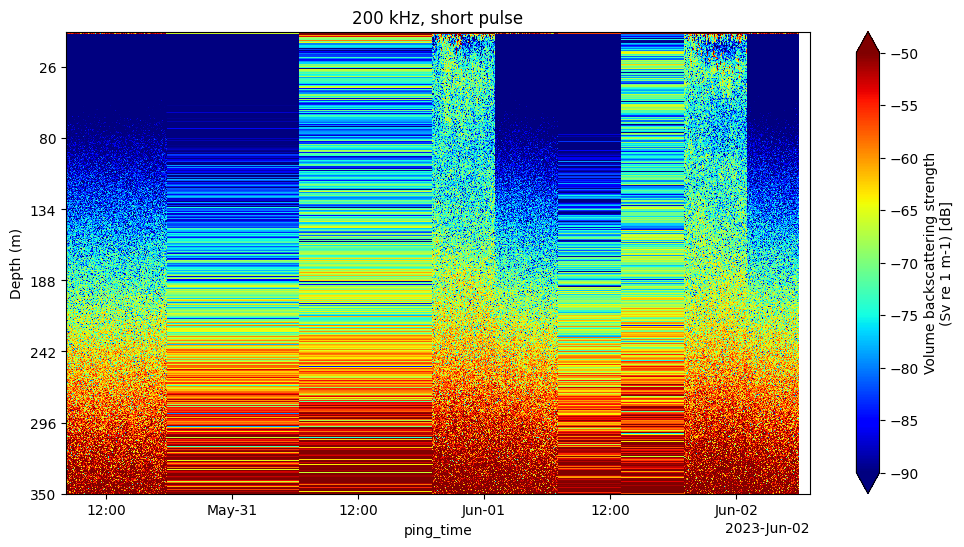

6189

In [67]:
# For zarr_G2 with different frequency
plot_echogram(ds_Sv, frequency=200000, title='200 kHz, short pulse',y_limit=(1300,0),scale_factor=3.71)

del Sv_G2, ds_Sv
gc.collect()

## 38 kHz long pulse subset

The time arrays are not equal and cannot be harmonized directly.
An error occurred: Dimension 'time1' not found in data dimensions ('ping_time',)


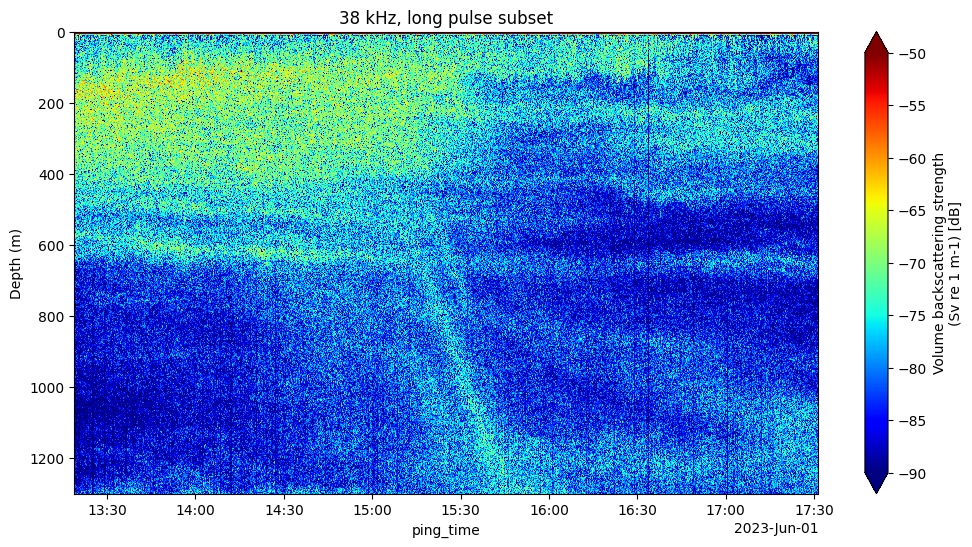

In [13]:
# For zarr_G1 subset
combined_ed_G1_copy = zarr_G1
combined_ed_G1_copy.beam = combined_ed_G1_copy.beam.isel(ping_time=slice(9000, 15000))
Sv_G1 = ep.calibrate.compute_Sv(
    combined_ed_G1_copy, waveform_mode="CW", encode_mode="complex"
).compute()
ds_Sv = ep.consolidate.swap_dims_channel_frequency(Sv_G1)
plot_echogram(ds_Sv, frequency=38000, title='38 kHz, long pulse subset')

## 38 kHz short pulse subset

The time arrays are not equal and cannot be harmonized directly.
An error occurred: Dimension 'time1' not found in data dimensions ('ping_time',)


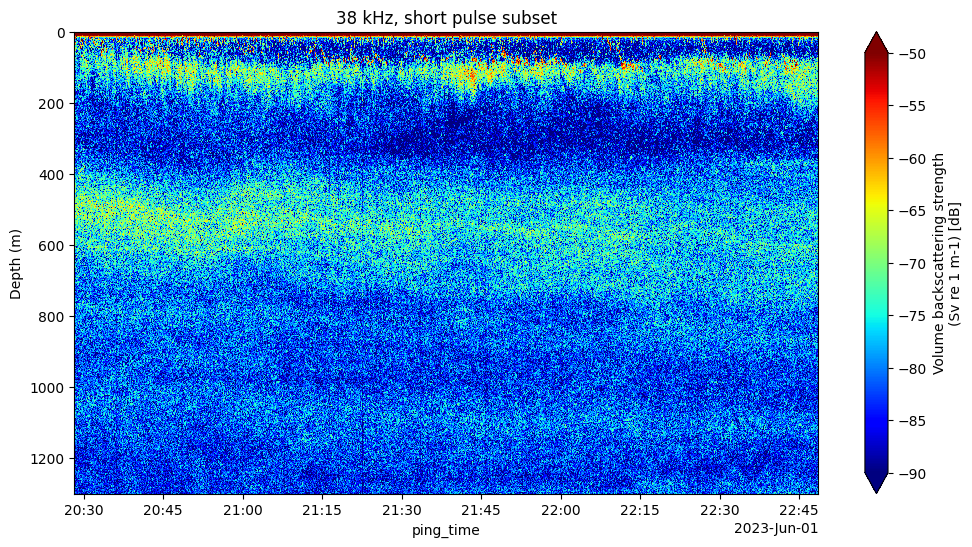

In [14]:
# For zarr_G2 subset
combined_ed_G2_copy = zarr_G2
combined_ed_G2_copy.beam = combined_ed_G2_copy.beam.isel(ping_time=slice(19000, 22000))
Sv_G2 = ep.calibrate.compute_Sv(
    combined_ed_G2_copy, waveform_mode="CW", encode_mode="complex"
).compute()
ds_Sv = ep.consolidate.swap_dims_channel_frequency(Sv_G2)
plot_echogram(ds_Sv, frequency=38000, title='38 kHz, short pulse subset')

## 200 kHz short pulse subset

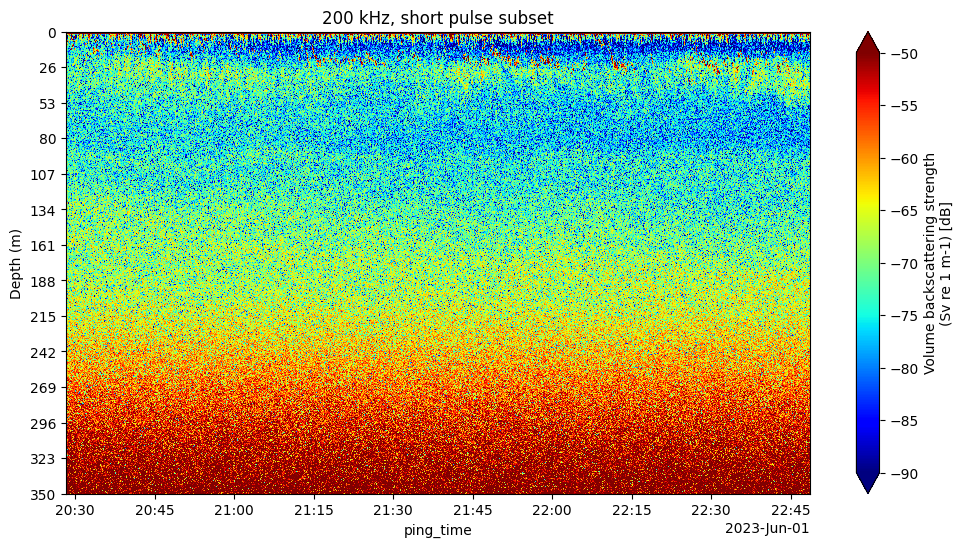

In [53]:
# For zarr_G2 with different frequency and subset
plot_echogram(ds_Sv, frequency=200000, y_limit=(1300,0), title='200 kHz, short pulse subset',scale_factor=3.71)